In [30]:
import os
from typing import List
import tensorflow as tf

# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

In [31]:
path_to_file

'/Users/emmanuelsarpong/.keras/datasets/spa-eng/spa.txt'

In [32]:
import unicodedata
import re


def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = ' ' + w + ' '
    return w

In [33]:
from archive.lib.language_index import LanguageIndex


def create_dataset(path: str, num_examples: int) -> tuple[List[str], List[str]]:
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(sentence) for sentence in l.split('\t')] for l in lines[:num_examples]]
    return [inp for inp, targ in word_pairs], [targ for inp, targ in word_pairs]


def load_dataset(path: str, num_examples: int):
    en, sp = create_dataset(path, num_examples)

    return LanguageIndex([s.split(' ') for s in sp]), LanguageIndex([e.split(' ') for e in en])

In [34]:
inp_lang, targ_lang = load_dataset(path_to_file, 10000)

In [35]:
from sklearn.model_selection import train_test_split

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    inp_lang.tensor(),
    targ_lang.tensor(),
    test_size=0.2
)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(8000, 8000, 2000, 2000)

In [78]:
from keras import Model, layers


class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, units):
        super(Encoder, self).__init__()
        self.units = units
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x):
        """
        :param x: (batch_size, timesteps) input tensor / sentences
        :return: (batch_size, timesteps)
        """
        embeddings = self.embedding(x)  # shape = (batch_size, timesteps, embedding_dim)
        sequences, state = self.gru(embeddings)  # shape = (batch_size, timesteps, units), (batch_size, units)
        return sequences, state


In [79]:
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, units):
        super(Decoder, self).__init__()
        self.units = units
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(units, recurrent_initializer='glorot_uniform')
        self.fc = layers.Dense(vocab_size)
        self.concat = layers.Concatenate(axis=-1)
        self.expand_second_axis = layers.Lambda(lambda x: tf.expand_dims(x, 1))

        self.attention = layers.Attention()

    def call(self, x, enc_sequences, initial_state):
        """
        :param x: (batch_size, 1) Nth word of all the sentences together (batch_size, 1)
        :param initial_state: (batch_size, units) Hidden state per sentence (initially from the encoder)
        :param enc_sequences: (batch_size, sequence_length, units) Static from encoder with all hidden states in return_sequences=True
        :return: (batch_size, seq_len, units)
        """
        embeddings = self.embedding(x)  # shape == (batch_size, 1, embedding_dim)

        previous_output = initial_state
        previous_output = self.expand_second_axis(previous_output)  # shape == (batch_size, 1, units)

        # (batch_size, 1, units), (batch_size, sequence_length, units)
        context_vector, attention_weights = self.attention([previous_output, enc_sequences],
                                                           return_attention_scores=True)

        rnn_input = self.concat([context_vector, embeddings])  # shape == (batch_size, 1, embedding_dim + units)

        state = self.gru(rnn_input)  # shape = (batch_size, 1, units), (batch_size, units)
        output = self.fc(state)  # shape = (batch_size, vocab_size)

        return output, state, attention_weights


In [81]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE // BATCH_SIZE
embedding_dim = 256
units = 1024

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

encoder = Encoder(len(inp_lang.word2idx) + 1, embedding_dim, units)
decoder = Decoder(len(targ_lang.word2idx) + 1, embedding_dim, units)

In [113]:
from keras import optimizers
import numpy as np

optimizer = optimizers.legacy.Adam()


def loss_function(real, pred):
    mask = 1 - tf.cast(tf.equal(real, 0), tf.float32)  # Convert boolean mask to float32
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [83]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [86]:
import time

EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (inp_sentences, targ)) in enumerate(dataset):
        loss = 0

        with tf.GradientTape() as tape:
            enc_output, hidden = encoder(inp_sentences)
            dec_input = targ_lang.zero_idx * tf.ones((BATCH_SIZE, 1))  # Start word [''] of each sentence in the batch

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                predictions, hidden, _ = decoder(dec_input, enc_output, hidden)

                next_words = targ[:, t]  # Next word of each sentence as (BATCH_SIZE)
                loss += loss_function(next_words, predictions)
                dec_input = tf.expand_dims(next_words, 1)

        batch_loss = loss / int(targ.shape[1])
        total_loss += batch_loss

        variables = encoder.variables + decoder.variables

        optimizer.apply_gradients(zip(tape.gradient(loss, variables), variables))

        if batch % 10 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9325
Epoch 1 Batch 10 Loss 1.8347
Epoch 1 Batch 20 Loss 1.7729
Epoch 1 Batch 30 Loss 1.8199
Epoch 1 Batch 40 Loss 1.8321
Epoch 1 Batch 50 Loss 1.8650
Epoch 1 Batch 60 Loss 1.8977
Epoch 1 Batch 70 Loss 1.6224
Epoch 1 Batch 80 Loss 1.9455
Epoch 1 Batch 90 Loss 1.6971
Epoch 1 Batch 100 Loss 1.5356
Epoch 1 Batch 110 Loss 1.6744
Epoch 1 Batch 120 Loss 1.7672
Epoch 1 Loss 1.7742
Time taken for 1 epoch 49.689882040023804 sec

Epoch 2 Batch 0 Loss 1.4970
Epoch 2 Batch 10 Loss 1.5417
Epoch 2 Batch 20 Loss 1.7024
Epoch 2 Batch 30 Loss 1.6169
Epoch 2 Batch 40 Loss 1.5197
Epoch 2 Batch 50 Loss 1.5980
Epoch 2 Batch 60 Loss 1.5684
Epoch 2 Batch 70 Loss 1.5077
Epoch 2 Batch 80 Loss 1.4606
Epoch 2 Batch 90 Loss 1.5785
Epoch 2 Batch 100 Loss 1.4598
Epoch 2 Batch 110 Loss 1.5093
Epoch 2 Batch 120 Loss 1.5545
Epoch 2 Loss 1.5244
Time taken for 1 epoch 50.34532308578491 sec

Epoch 3 Batch 0 Loss 1.2945
Epoch 3 Batch 10 Loss 1.3567
Epoch 3 Batch 20 Loss 1.3384
Epoch 3 Batch 30 Loss 1

In [218]:
from keras import Model, layers, optimizers


class Seq2Seq(Model):
    def __init__(self, encoder, decoder, sos_token):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_token = sos_token

    def call(self, inputs, training=False):
        inp_sentences = inputs[0]
        enc_output, enc_hidden = self.encoder(inp_sentences)
        dec_input = self.sos_token * tf.ones((inp_sentences.shape[0], 1))

        all_predictions = []
        dec_hidden = enc_hidden

        if training:
            targ = inputs[1]
            for t in range(targ.shape[1]):
                predictions, dec_hidden, _ = self.decoder(dec_input, enc_output, dec_hidden)
                dec_input = tf.expand_dims(targ[:, t], 1)  # Teacher forcing
                all_predictions.append(predictions)
        else:
            while len(all_predictions) < 100 or all_predictions[-1] == self.sos_token:
                predictions, dec_hidden, _ = self.decoder(dec_input, enc_output, dec_hidden)
                predicted_id = tf.argmax(predictions, axis=-1)
                dec_input = tf.expand_dims(predicted_id, 1)
                all_predictions.append(predicted_id)

        all_predictions = tf.stack(all_predictions, axis=1)
        return all_predictions


In [219]:
seq2seq_model = Seq2Seq(encoder, decoder, targ_lang.zero_idx)

seq2seq_model.compile(optimizer=optimizers.legacy.Adam(), loss=loss_function, metrics=['accuracy'])

In [220]:
seq2seq_model.fit([input_tensor_train, target_tensor_train], target_tensor_train, epochs=1, batch_size=BATCH_SIZE)

W0000 00:00:1708393250.154381       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1708393250.154533       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 26843

125/125 [==============================] - 29s 195ms/step - loss: 0.0467 - accuracy: 0.7655


In [221]:
from keras.preprocessing import sequence

input_seq = sequence.pad_sequences(
    [inp_lang[preprocess_sentence(u'tengo hambre').split(' ')]],
    maxlen=inp_lang.max_length,
    padding='post',
    value=inp_lang.zero_idx
)

predicted_sequences = seq2seq_model.predict([input_seq], verbose=1, batch_size=1)
print(type(predicted_sequences[0][0]))

output = ' '.join(targ_lang[predicted_sequences[0].tolist()])
print(output)

NotImplementedError: in user code:

    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/fk/6lvr7z756yjcvwrjfwxbtl8c0000gp/T/__autograph_generated_filen5p8_3nt.py", line 73, in tf__call
        ag__.if_stmt(ag__.ld(training), if_body, else_body, get_state_2, set_state_2, ('dec_hidden', 'dec_input'), 0)
    File "/var/folders/fk/6lvr7z756yjcvwrjfwxbtl8c0000gp/T/__autograph_generated_filen5p8_3nt.py", line 67, in else_body
        ag__.while_stmt(loop_test, loop_body_1, get_state_1, set_state_1, ('dec_hidden', 'dec_input'), {})

    NotImplementedError: Exception encountered when calling layer 'seq2_seq_31' (type Seq2Seq).
    
    in user code:
    
        File "/var/folders/fk/6lvr7z756yjcvwrjfwxbtl8c0000gp/T/ipykernel_65405/4238803862.py", line 26, in call  *
            while len(all_predictions) < 100 or all_predictions[-1] == self.sos_token:
    
        NotImplementedError: The condition of while loop started as non-Tensor, then changed to Tensor. This may happen either because variables changed type, or when a break or return statement inside the loop depends on a Tensor condition. In both cases, changing to a TF loop should remove the error.
        See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#consistency-of-control-flow-types for more info.
    
    
    Call arguments received by layer 'seq2_seq_31' (type Seq2Seq):
      • inputs=('tf.Tensor(shape=(1, 12), dtype=int32)',)
      • training=False


In [119]:
from keras.preprocessing import sequence


def evaluate(sentence, encoder, decoder, inp_lang, targ_lang):
    attention_plot = np.zeros((targ_lang.max_length, inp_lang.max_length))

    sentence = preprocess_sentence(sentence)

    inputs = tf.convert_to_tensor(
        sequence.pad_sequences(
            [inp_lang[sentence.split(' ')]],
            maxlen=inp_lang.max_length,
            padding='post',
            value=inp_lang.zero_idx
        )
    )

    result = ''

    dec_input = targ_lang.zero_idx

    enc_sequences, state = encoder(inputs)

    for t in range(targ_lang.max_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input * tf.ones((1, 1)), enc_sequences, state)

        dec_input = int(tf.argmax(predictions[0]).numpy())

        result += targ_lang[dec_input] + ' '
        attention_plot[t] = tf.reshape(attention_weights, (-1,)).numpy()

        if targ_lang[dec_input] == '':
            return result, sentence, attention_plot

    return result, sentence, attention_plot

In [60]:
from matplotlib import pyplot as plt


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='Greys')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [61]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang)

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input:  tengo hambre 
Predicted translation:  


/var/folders/fk/6lvr7z756yjcvwrjfwxbtl8c0000gp/T/ipykernel_65405/357755776.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/fk/6lvr7z756yjcvwrjfwxbtl8c0000gp/T/ipykernel_65405/357755776.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


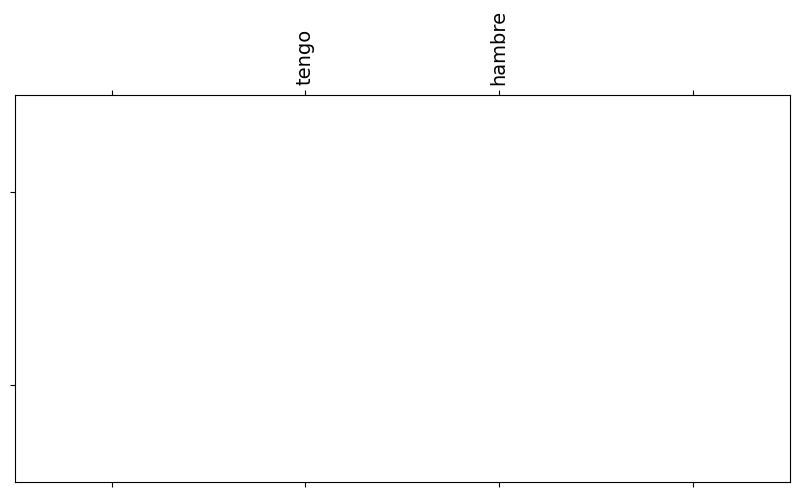

In [121]:
translate(u'tengo hambre')

Input:  tengo 
Predicted translation:  


/var/folders/fk/6lvr7z756yjcvwrjfwxbtl8c0000gp/T/ipykernel_65405/357755776.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/fk/6lvr7z756yjcvwrjfwxbtl8c0000gp/T/ipykernel_65405/357755776.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


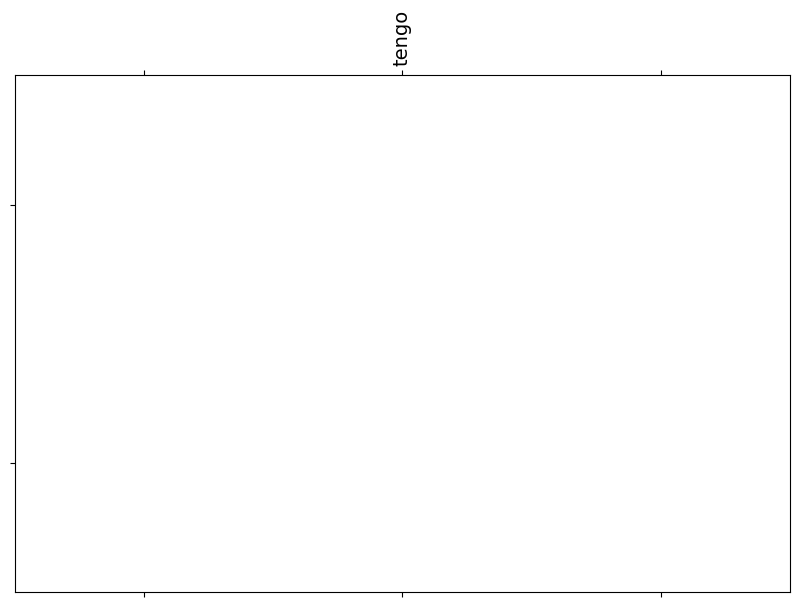

In [122]:
translate(u'tengo')

In [ ]:
encoder.variables

In [133]:
seq2seq_model.save('../data/output/_z098-seq2seq-nmt-with-attention.keras')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)
